# Task 03 - NBA Matches Winner Prediction

Débora Mayumi Rissato - 5288223

Douglas Decicino de Andrade - 10883512

Paulino Ribeiro Villas Boas - 2950178

Renan Silva Chun - 10691817

Renan de Oliveira da Cruz - 10801090

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
import traceback
import re
from pandas import Series
import pandas.core.algorithms as algos

In [2]:
data_train = pd.read_csv("../input/task-03/train_full.csv")
data_test = pd.read_csv("../input/task-03/test_without_label.csv")

# 1) Análise dos dados brutos. 



In [3]:
data_train

,Game,Data,H_Team,H_Wins,H_Loss,H_W/D %,H_SRS,H_Games,H_TotalPoints,H_AvgPointsPerGame,...,A_TS%,A_eFG%,A_TOV%,A_ORB%,A_FT/FGA,A_OeFG%,A_OTOV%,A_DRB%,A_OFT/FGA,WinOrLose
0,0,"Thu, June 8",Miami Heat,52,30,0.634,3.59,82,8191,99.9,...,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
1,1,"Sun, June 11",Miami Heat,52,30,0.634,3.59,82,8191,99.9,...,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
2,2,"Tue, June 13",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
3,3,"Thu, June 15",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
4,4,"Sun, June 18",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1001,"Fri, April 21",Los Angeles Clippers,51,31,0.622,4.42,82,8911,108.7,...,0.563,0.526,13.2,23.2,0.215,0.493,11.8,78.9,0.195,W
1002,1002,"Sun, April 23",Los Angeles Clippers,51,31,0.622,4.42,82,8911,108.7,...,0.563,0.526,13.2,23.2,0.215,0.493,11.8,78.9,0.195,L
1003,1003,"Tue, April 25",Utah Jazz,51,31,0.622,4.00,82,8258,100.7,...,0.574,0.537,12.0,21.5,0.233,0.506,12.1,76.9,0.211,W
1004,1004,"Fri, April 28",Los Angeles Clippers,51,31,0.622,4.42,82,8911,108.7,...,0.563,0.526,13.2,23.2,0.215,0.493,11.8,78.9,0.195,W


Verificando valores ausentes nos dados.

In [4]:
print("Valores ausentes data de treinamento: ", data_train.isnull().values.any())
print("Valores ausentes data de teste: ", data_test.isnull().values.any())

Valores ausentes data de treinamento:  False
Valores ausentes data de teste:  False


Nota-se que os dados não apresentam valores ausentes. 

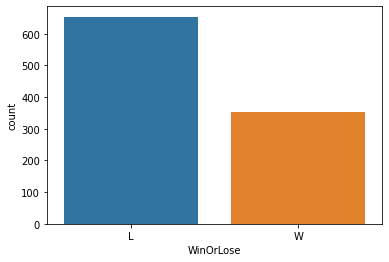

In [5]:
# Verificando se há desbalanceamento das classes da variável resposta
sns.countplot(x = 'WinOrLose', data=data_train)
plt.show()

# 2) Transformações e Feature engineering

**Pega o mês e o dia da semana da "Data" (adaptada do notebook NBA - 71% public)**

Pode indicar alguma tendência dos times perderem em casa ou fora conforme o dia da semana ou mês

In [6]:
def getData(df):
    """
    Pega dia da semana e mes que ocorreu o jogo
    """
    
    df["WeekDay"] = df["Data "].apply(lambda x : x.split(" ")[0].strip(","))
    df["Month"] = df["Data "].apply(lambda x : x.split(" ")[1])
    
    weekdays = {'Mon':1 ,'Tue':2, 'Wed':3,'Thu':4, 'Fri':5,'Sat':6,'Sun':7}
    df["WeekDay"] = df["WeekDay"].replace(weekdays)
    
    months = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7,
             "August":8, "September":9, "October":10, "November":11, "December":12}
    
    df["Month"] = df["Month"].replace(months)
    df["Month"] = df["Month"].replace({8:4, 9:5, 10:6}) # Playoffs de 2020 atrasaram...
    
    
    columns_to_drop = ["Data "]
    df.drop(columns_to_drop, axis = 1, inplace = True)
    
    return df

**Pega o ano dos jogos (fonte: notebook NBA - 71% public)**

Pode indicar para o classificador que alguma tendência está mudando com o passar dos anos

In [7]:
def getAno(train, test):
    
    qnt_anos_train = [89, 79, 86, 85, 82, 81, 84, 85, 89, 81, 86, 79]
    qnt_anos_test = [82, 83]
    
    train_ano = np.repeat(list(range(2006, 2018)), qnt_anos_train)
    test_ano = np.repeat([2018,2019], qnt_anos_test)
    
    train["Year"] = train_ano
    test["Year"] = test_ano

    return train, test

**Transforma as variáveis dos times**

Pode ser útil para reduzir o número de variáveis, considerando apenas a relação entre as variáveis do time da casa e as do time de fora

In [8]:
#o resultado do paulino foi sem usar essa função
#def transform_variables(data, isTRAIN = True):
    
    # sub = pd.DataFrame(data.iloc[: ,np.arange(3,68)].values-
    #                    data.iloc[:,np.arange(69,134)].values, columns=data_train.columns[np.arange(3,68)])
    # add = pd.DataFrame(data.iloc[: ,np.arange(3,68)].values+
    #                    data.iloc[:,np.arange(69,134)].values, columns=data_train.columns[np.arange(3,68)])
    
    # #print(sub.shape)
    # #print(add.shape)
    
    # matrix_div = sub.div(add)
   
    # matrix_div.loc[:, "Game"] = data.loc[:, "Game"]
    # matrix_div.loc[:, "Data "] = data.loc[:, "Data "]
    # matrix_div.loc[:, "H_Team "] = data.loc[:, "H_Team "]
    # matrix_div.loc[:, "A_Team "] = data.loc[:, "A_Team "]
    
    # if isTRAIN:
    #     matrix_div.loc[:, "WinOrLose"] = data.loc[:, "WinOrLose"]
    
    # return matrix_div

**Obtem número de jogos em casa e fora por playoff**

Pode ser útil para diferenciar os jogos que acontecem dentro e fora de casa para cada playoff



In [9]:
def new_data(data):
    data.loc[:, "Home_Game"] = np.zeros(data.shape[0])
    data.loc[:, "Away_Game"] = np.zeros(data.shape[0])
    
    previousTeams = [data.loc[0, "H_Team "], data.loc[0, "A_Team "]]
    first = 0
    
    for i in np.arange(1, (data.shape[0])):
        if not(data.loc[i, "H_Team "]  in previousTeams) or not((data.loc[i, "A_Team "]  in previousTeams)):
            previousTeams = [data.loc[i, "H_Team "], data.loc[i, "A_Team "]]

            timeA = data.loc[i - 1, "H_Team "]  

            Ngame = 0
            for j in np.arange(first, i):
                Ngame +=1
                if data.loc[j, "H_Team "] == timeA:
                    data.loc[j, "Home_Game"] = Ngame
                else:
                    data.loc[j, "Away_Game"] = Ngame
            first = i

    timeA = data.loc[i - 1, "H_Team "]

    Ngame = 0
    for j in np.arange(first, i + 1):
        Ngame += 1
        if data.loc[j, "H_Team "] == timeA:
            data.loc[j, "Home_Game"] = Ngame
        else:
            data.loc[j, "Away_Game"] = Ngame
    
    return data

**Transformação dos dados**

Adiciona os jogos de dentro e fora de casa

In [10]:
data_train_ = new_data(data_train)
data_test_ = new_data(data_test)

In [11]:
data_train_.drop("H_SOS ", axis=1, inplace=True)
data_train_.drop("A_SOS ", axis=1, inplace=True)
data_test_.drop("H_SOS ", axis=1, inplace=True)
data_test_.drop("A_SOS ", axis=1, inplace=True)

Adiciona mês, dia da semana e ano nos dataframes

In [12]:
data_train = data_train_.copy()
data_test = data_test_.copy()

In [13]:
data_train = getData(data_train)
data_test = getData(data_test)

In [14]:
data_train, data_test = getAno(data_train, data_test)

In [15]:
data_train.shape

(1006, 137)

Verifica a variabilidade das variáveis

In [16]:
for aux in data_train.columns:
    if data_train.loc[:, aux].dtypes == 'int64' or data_train.loc[:, aux].dtypes == 'float64':
        print(aux, ":",round(np.std(data_train.loc[:, aux]), 4))

Game : 290.407
H_Wins  : 7.8723
H_Loss  : 7.3959
H_W/D %  : 0.0895
H_SRS  : 2.8743
H_Games  : 4.4237
H_TotalPoints  : 647.9424
H_AvgPointsPerGame  : 4.794
H_FG  : 1.7332
H_FGA  : 2.9798
H_FG%  : 0.0146
H_3P  : 2.0229
H_3PA  : 5.1207
H_3P%  : 0.0189
H_2P  : 1.9386
H_2PA  : 4.4221
H_2P%  : 0.0199
H_FT  : 1.9834
H_FTA  : 2.6555
H_FT%  : 0.0304
H_ORB  : 1.305
H_DRB  : 1.6902
H_TRB  : 1.9188
H_AST  : 2.1781
H_BLK  : 0.7967
H_TOV  : 1.0591
H_PF  : 1.5972
H_PointsOpp  : 614.8368
H_AvgPointsPerGameOpp  : 4.4617
H_OFG  : 1.7604
H_OFGA  : 3.3581
H_OFG%  : 0.0112
H_O3P  : 1.3352
H_O3PA  : 3.6723
H_O3P%  : 0.0137
H_O2P  : 1.4758
H_O2PA  : 3.2935
H_O2P%  : 0.0153
H_OFT  : 1.8106
H_OFTA  : 2.4122
H_OFT%  : 0.0135
H_OORB  : 0.8516
H_ODRB  : 1.7225
H_OTRB  : 1.9142
H_OAST  : 1.6736
H_OBLK  : 0.7061
H_OTOV  : 1.2558
H_OPF  : 1.4689
H_PW  : 7.8881
H_PL  : 7.5247
H_MOV  : 2.9069
H_Ortg  : 2.9798
H_Drtg  : 2.6797
H_Pace  : 2.8685
H_Ftr  : 0.0377
H_3PAr  : 0.0579
H_TS%  : 0.0182
H_eFG%  : 0.0199
H_TOV%  : 

Acima nota-se que nenhum dos atributos possui variabilidade zero.

Verifica as distribuições das variáveis (útil para seleção manual, principalmente para o classificador Naive Bayes). Distribuições diferentes entre "L" e "W" são úteis para o Naive Bayes, como por exemplo as variáveis H_W/D % e A_W/D % que são as proporções de vitórias do time da casa e do time de fora em cada jogo.

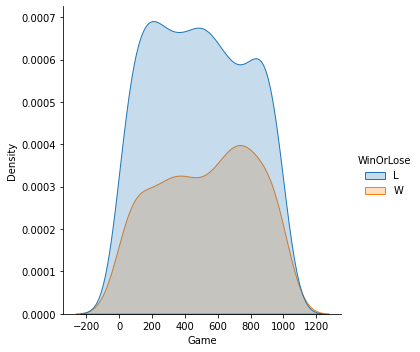

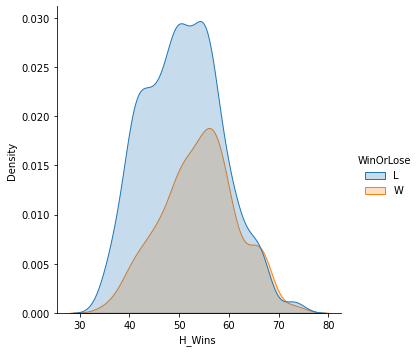

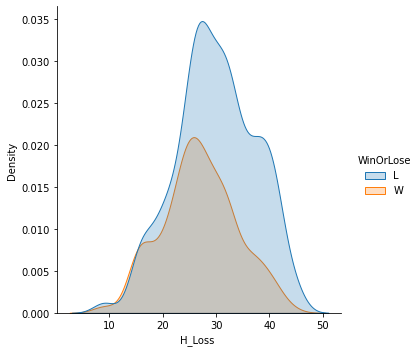

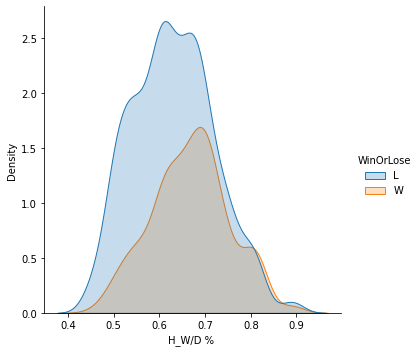

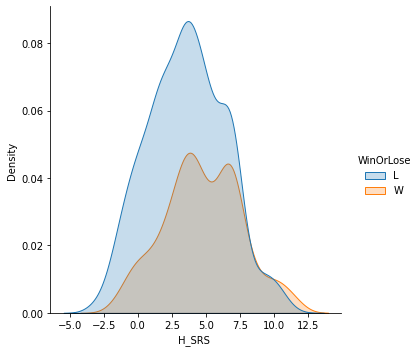

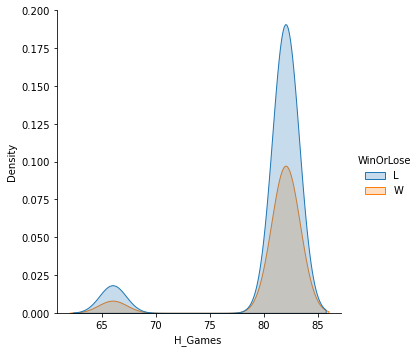

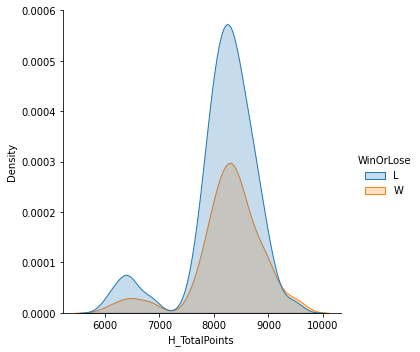

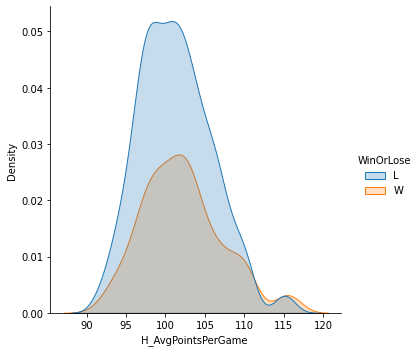

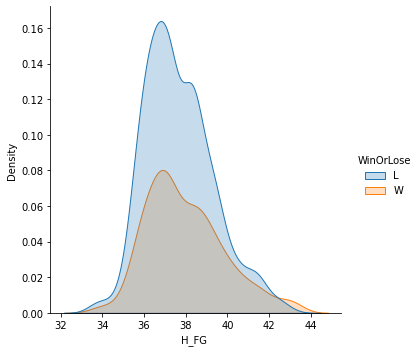

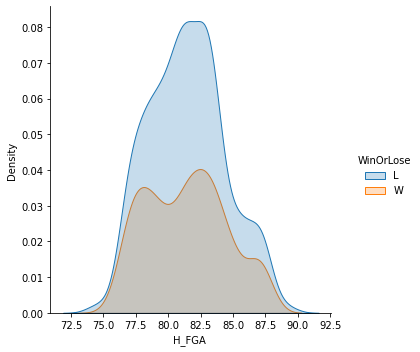

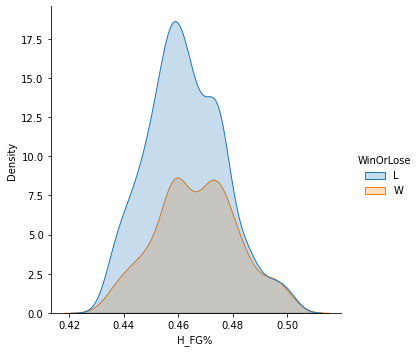

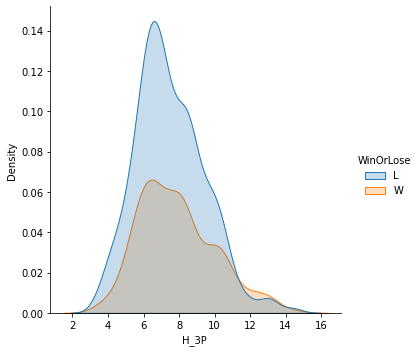

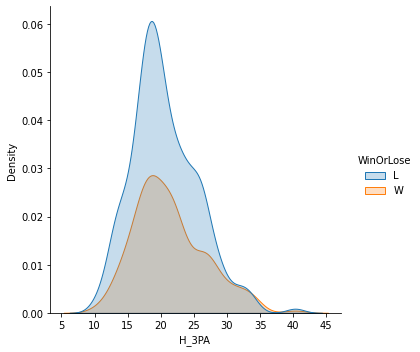

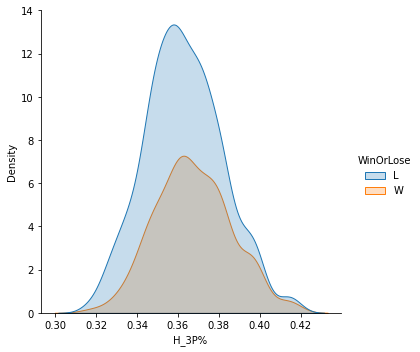

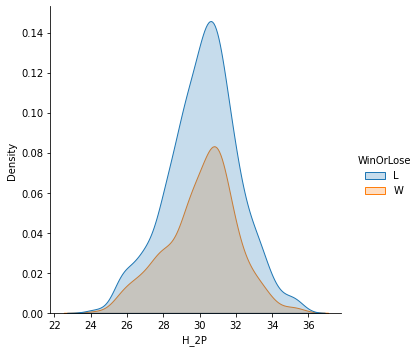

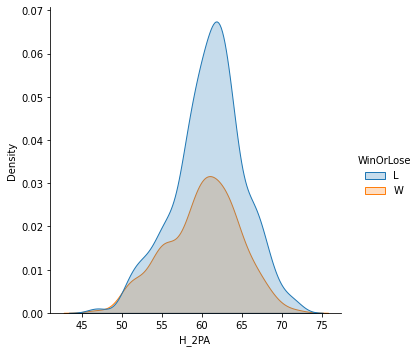

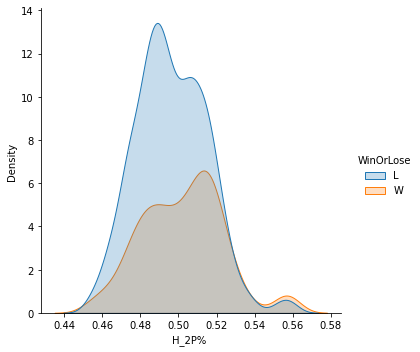

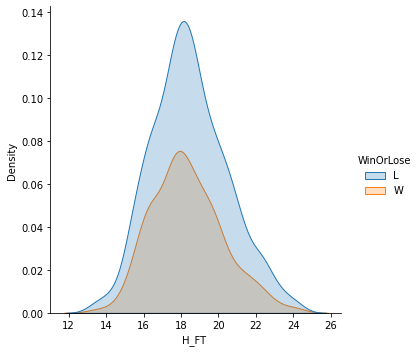

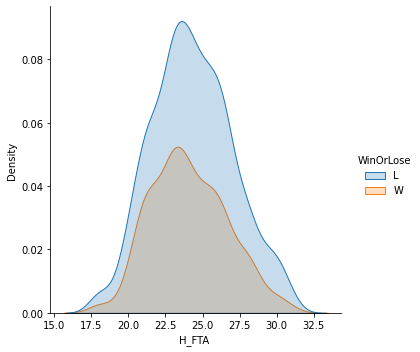

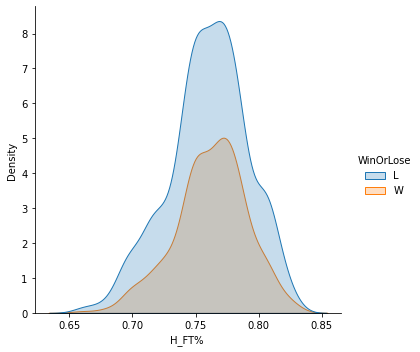

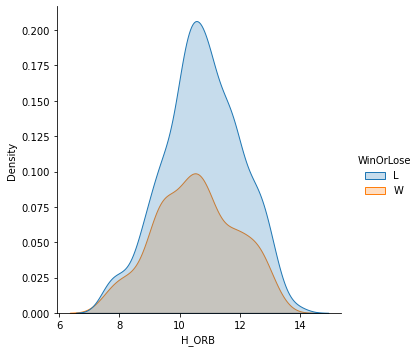

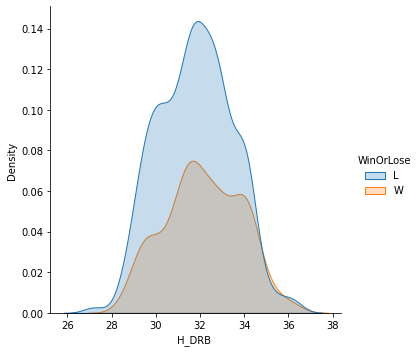

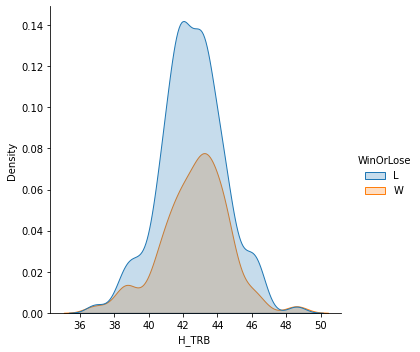

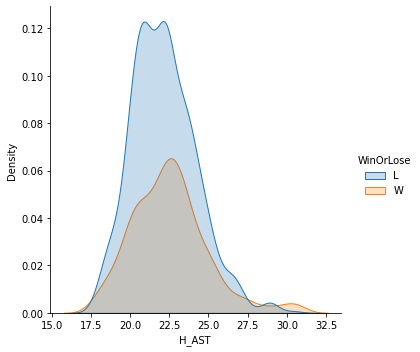

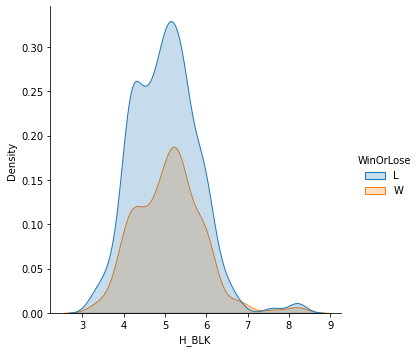

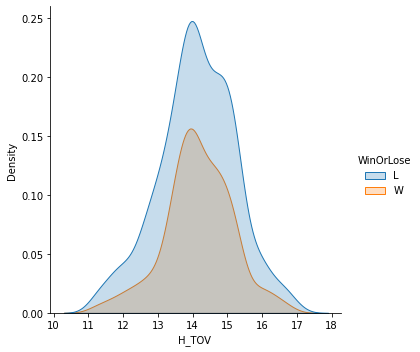

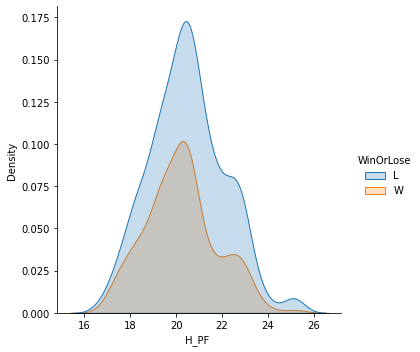

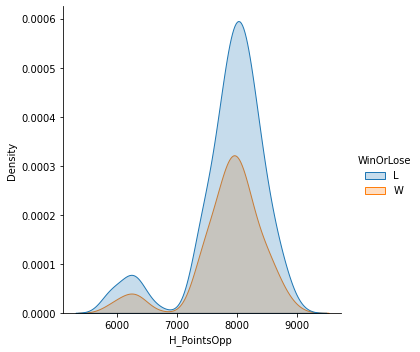

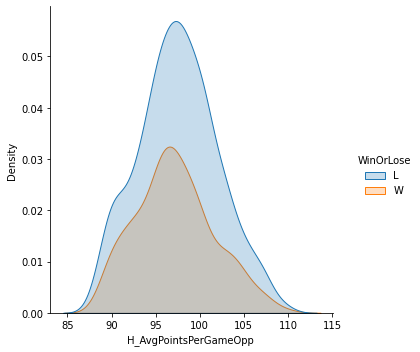

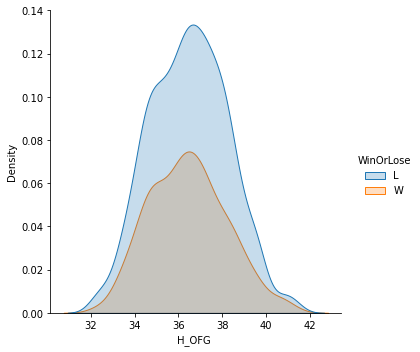

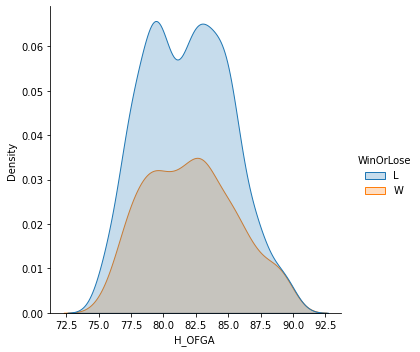

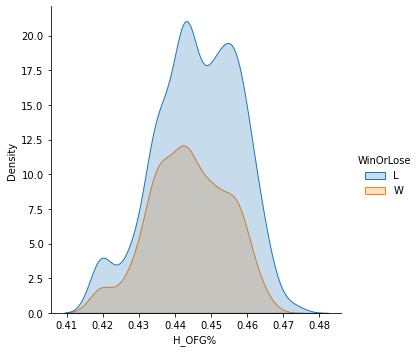

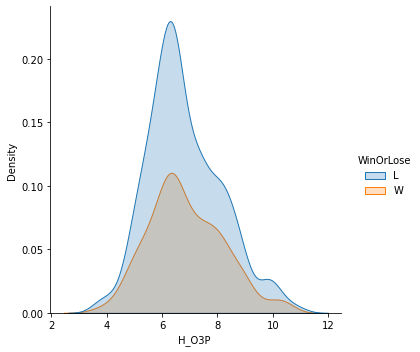

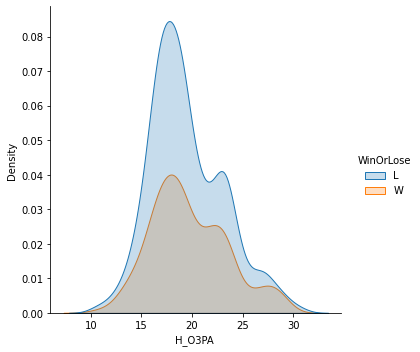

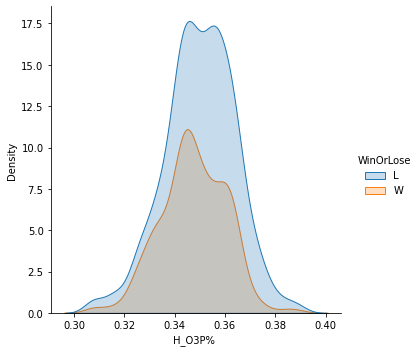

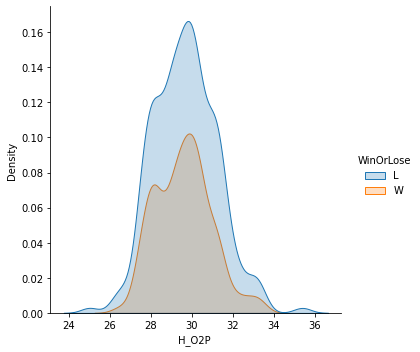

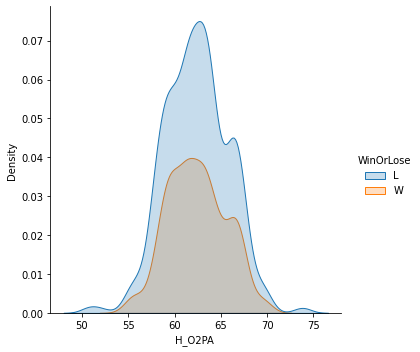

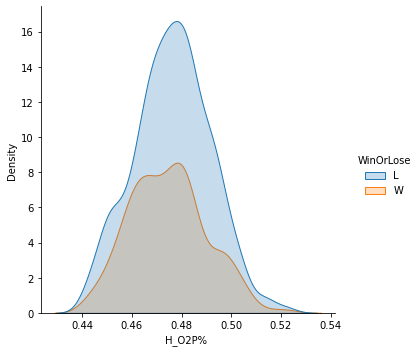

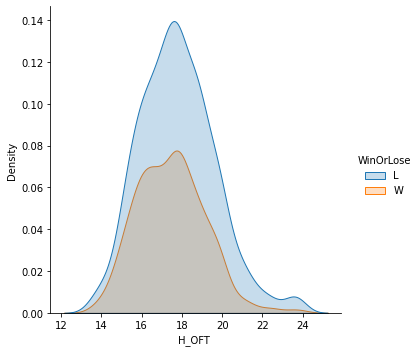

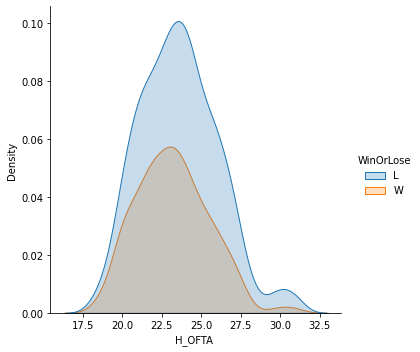

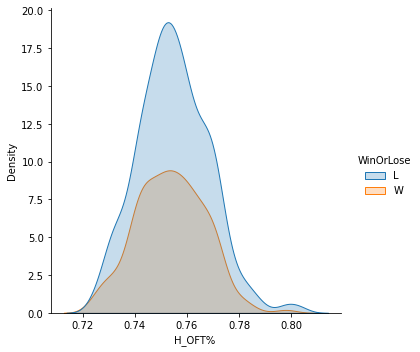

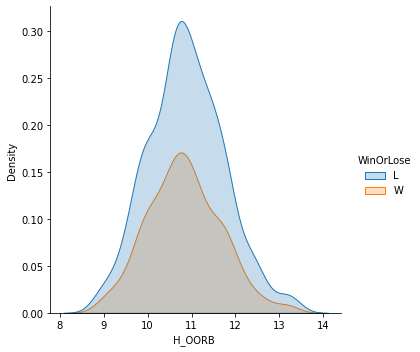

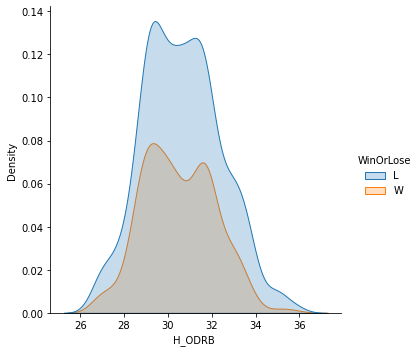

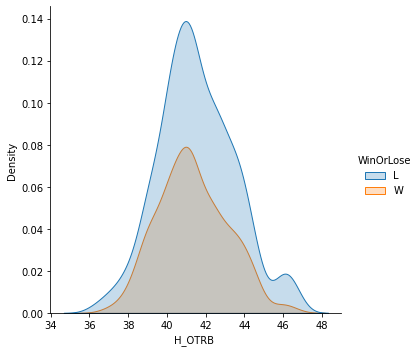

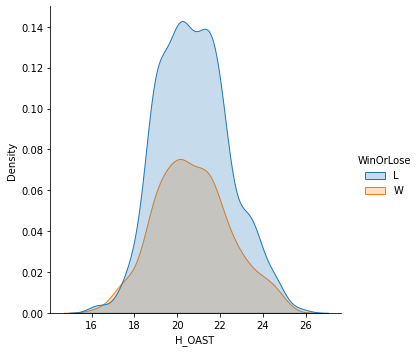

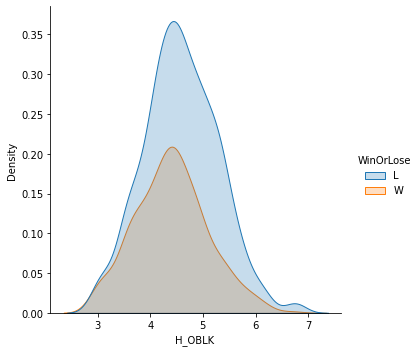

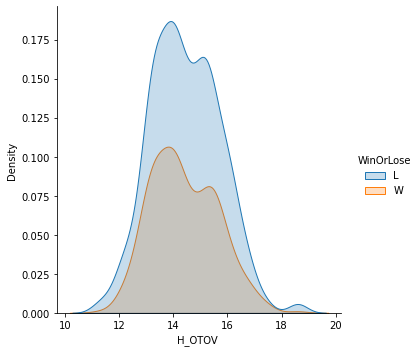

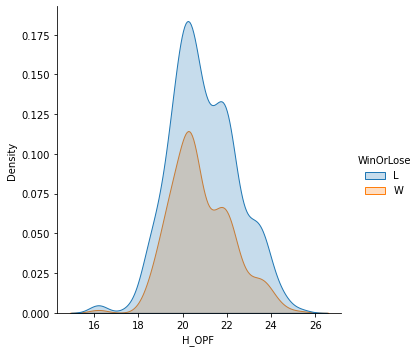

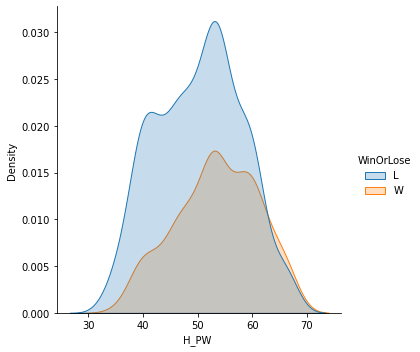

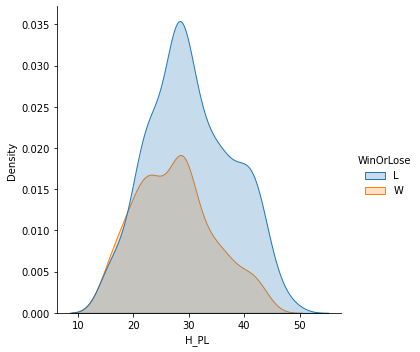

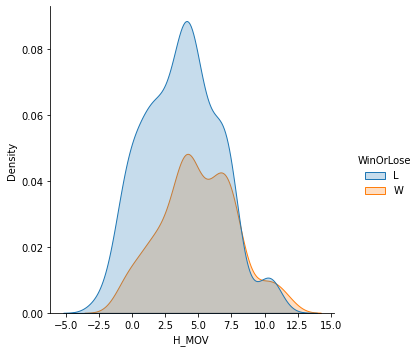

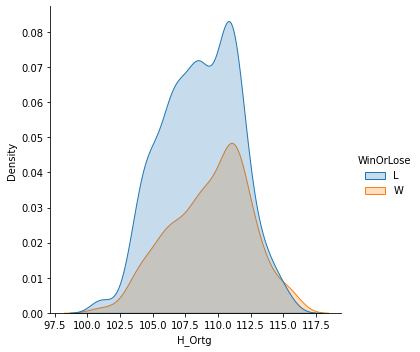

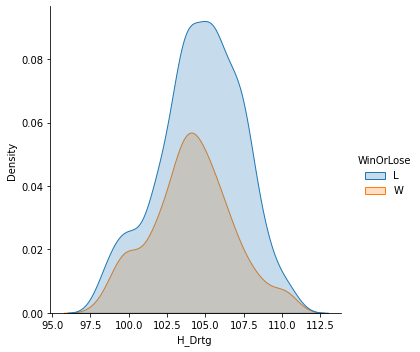

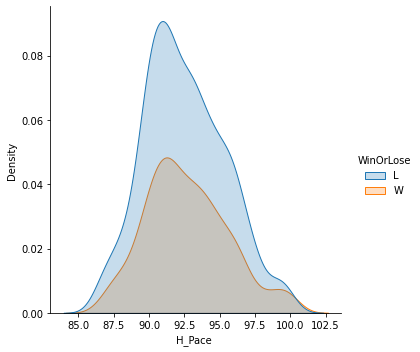

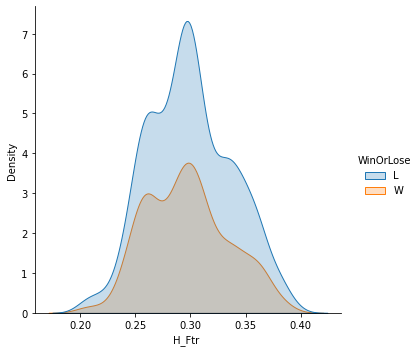

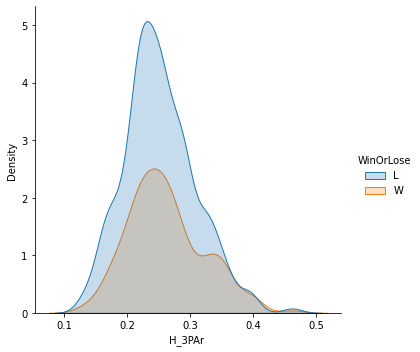

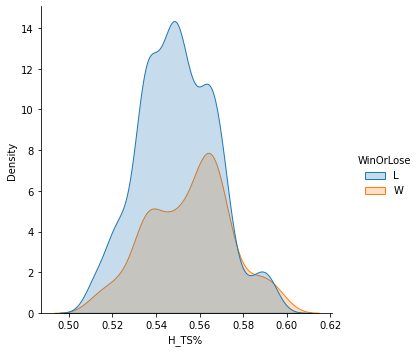

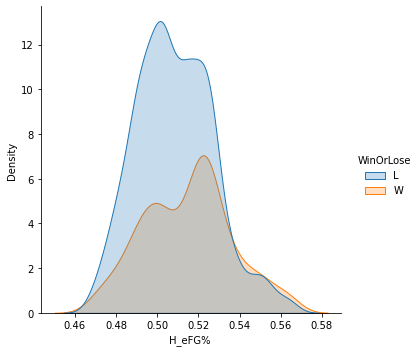

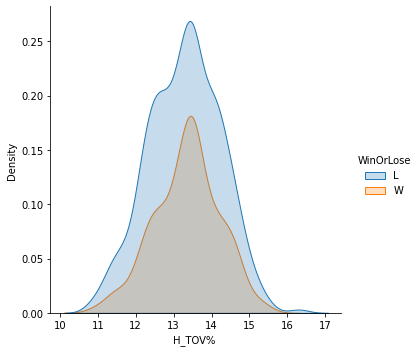

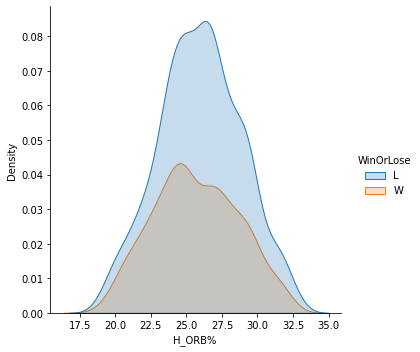

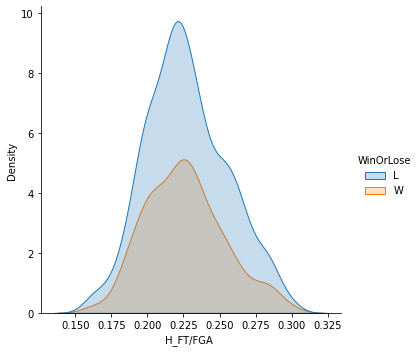

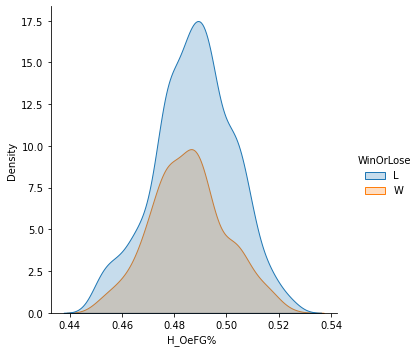

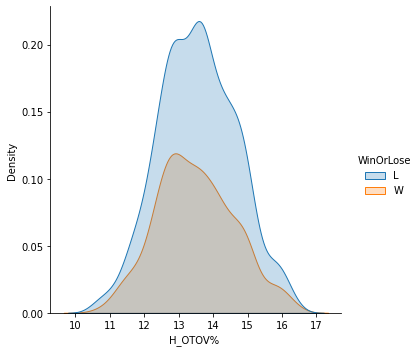

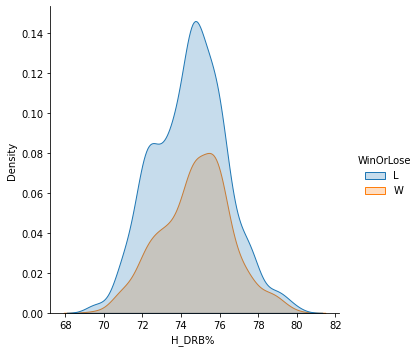

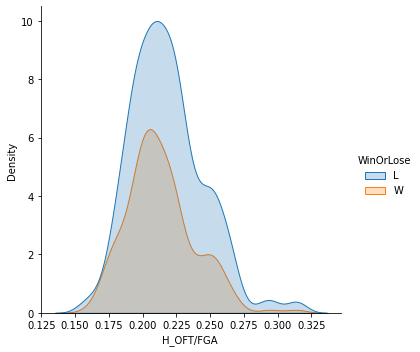

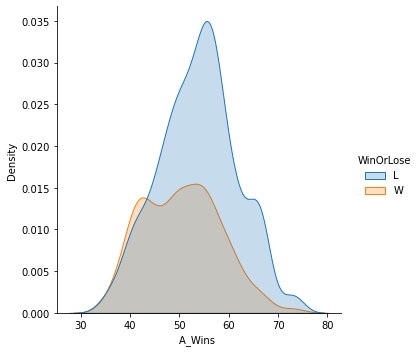

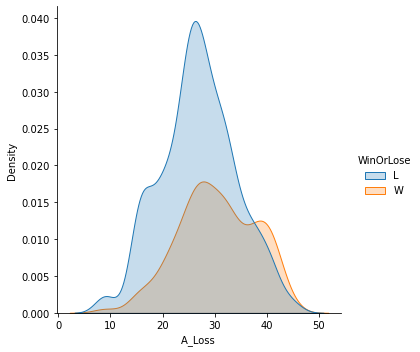

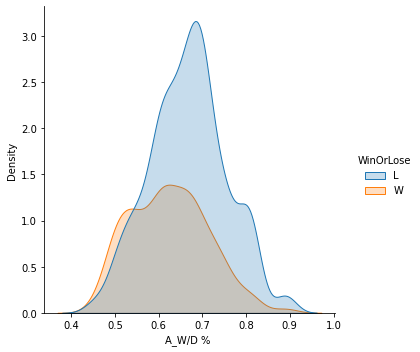

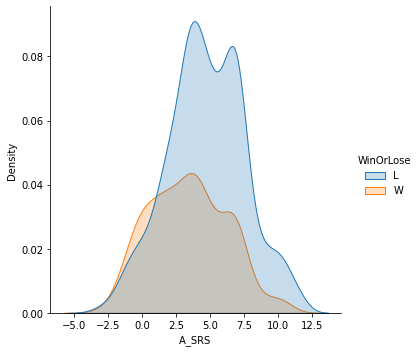

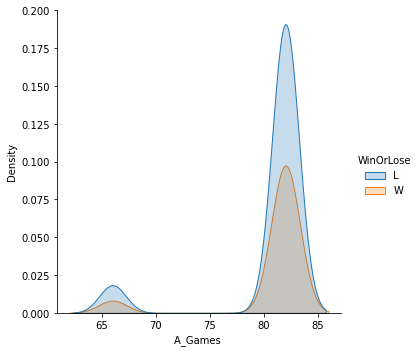

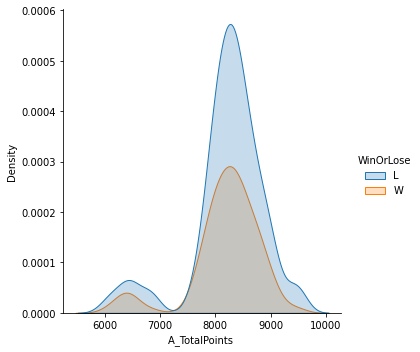

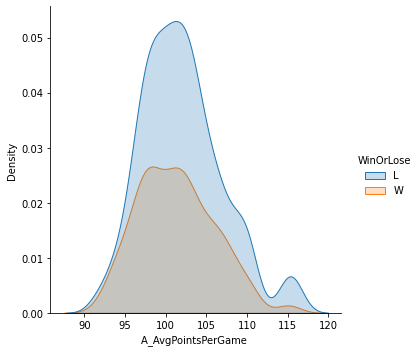

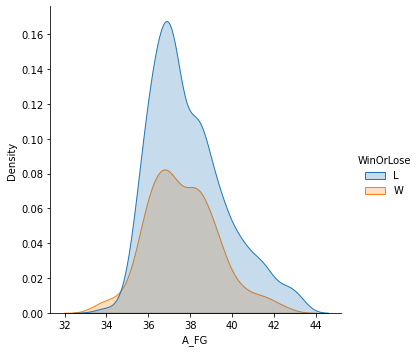

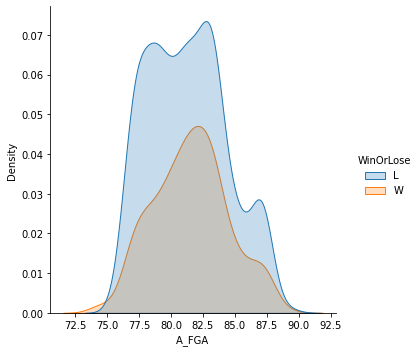

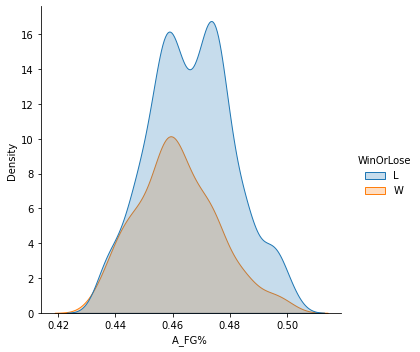

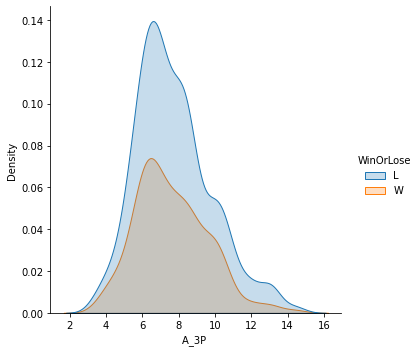

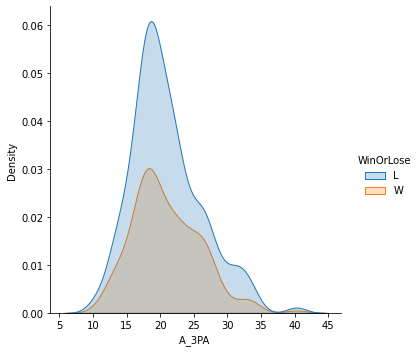

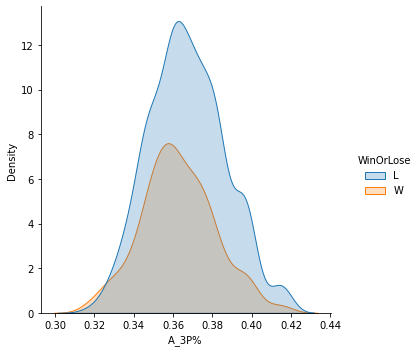

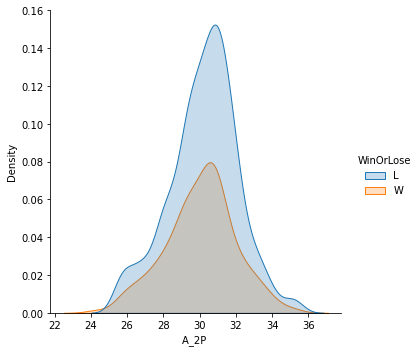

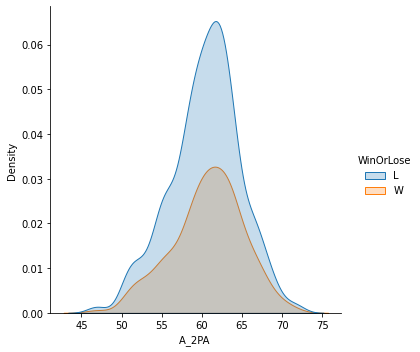

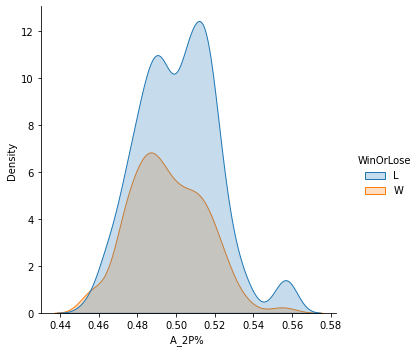

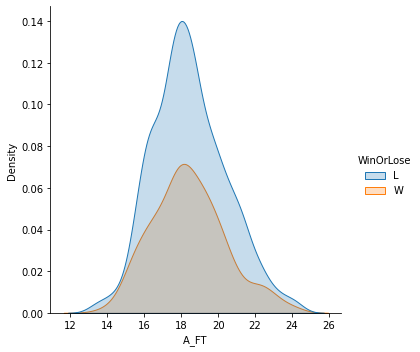

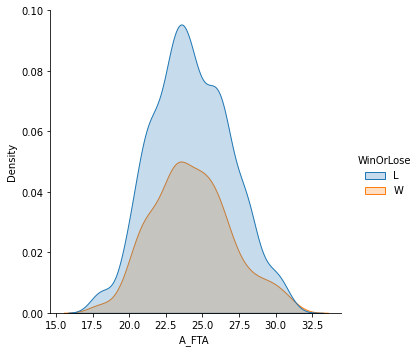

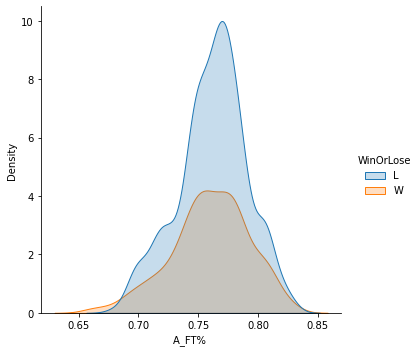

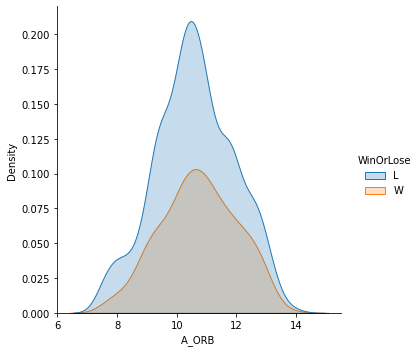

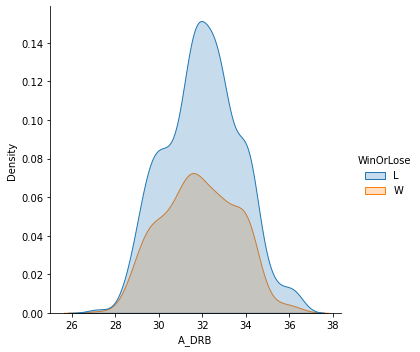

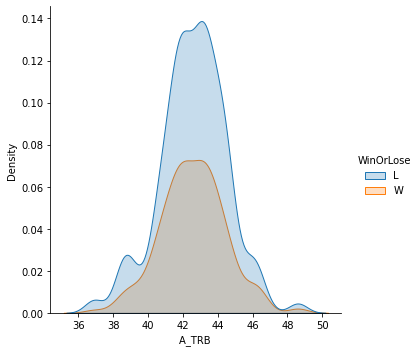

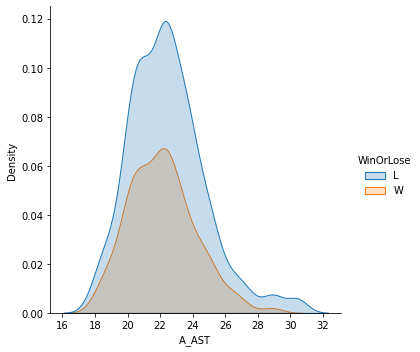

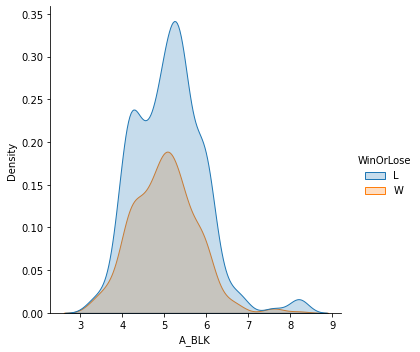

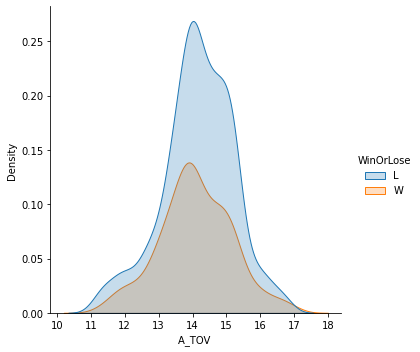

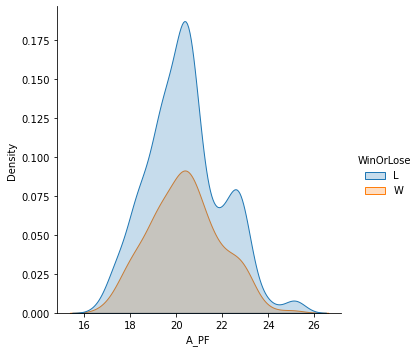

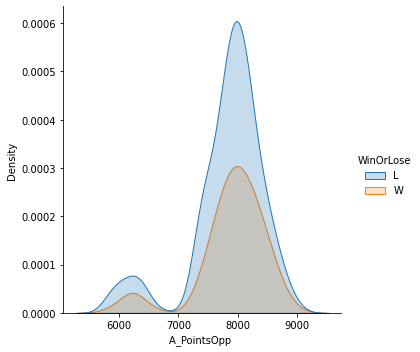

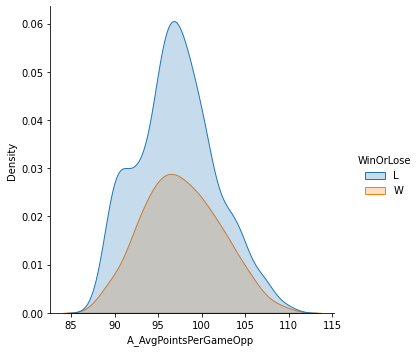

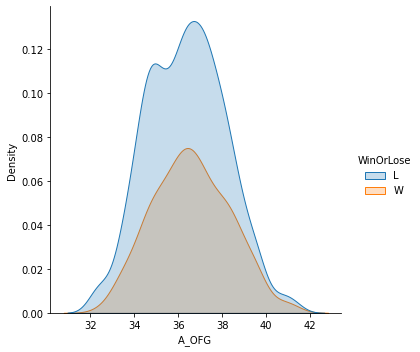

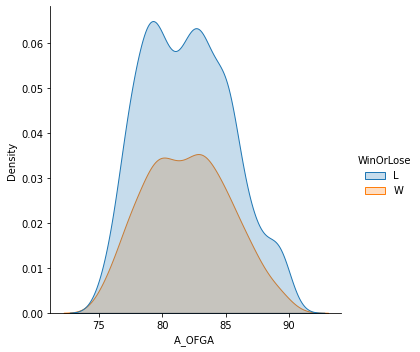

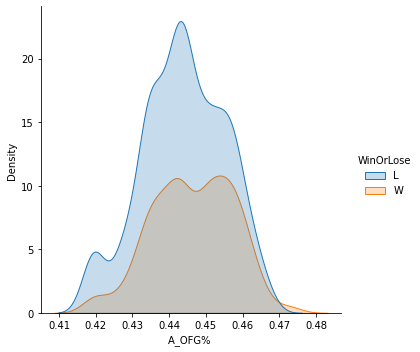

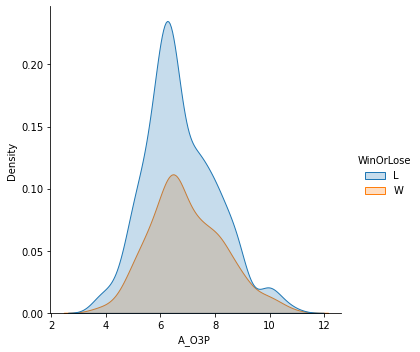

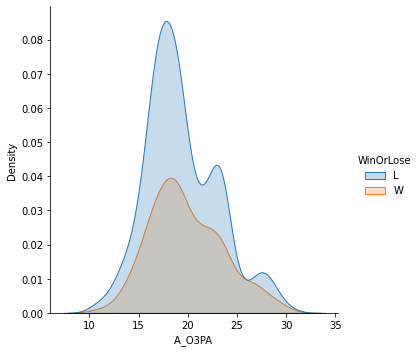

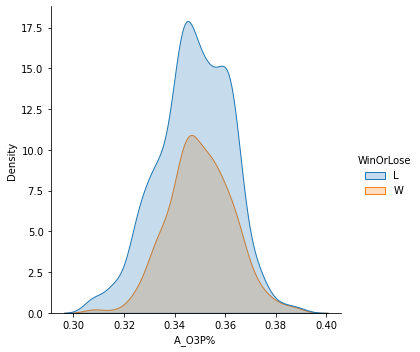

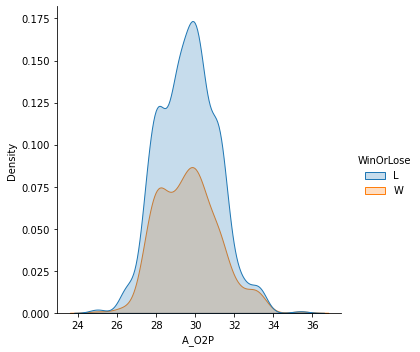

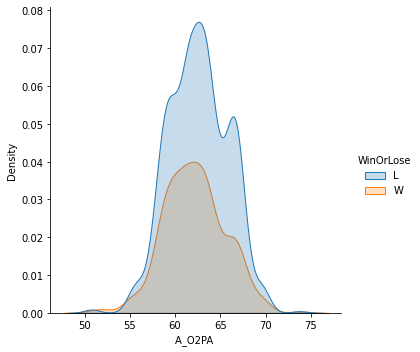

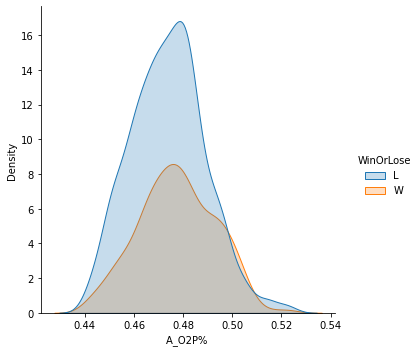

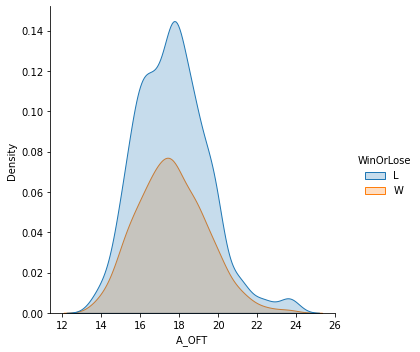

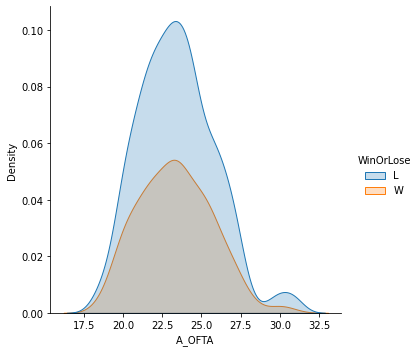

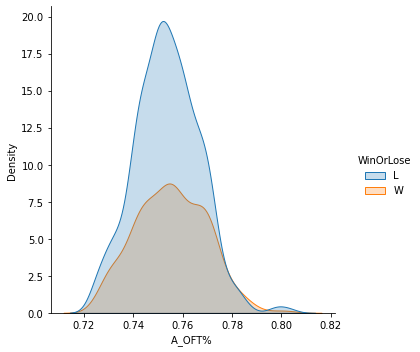

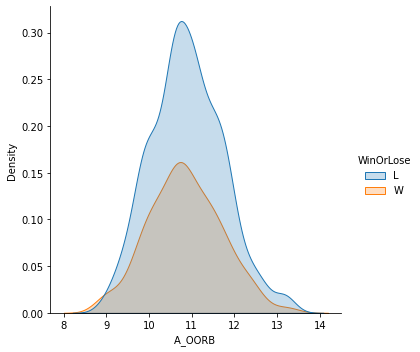

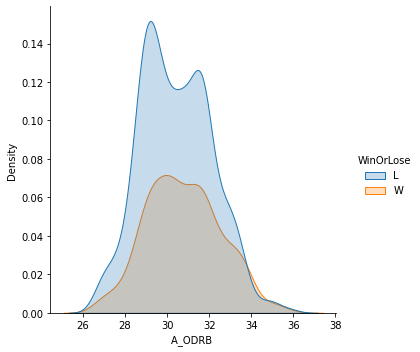

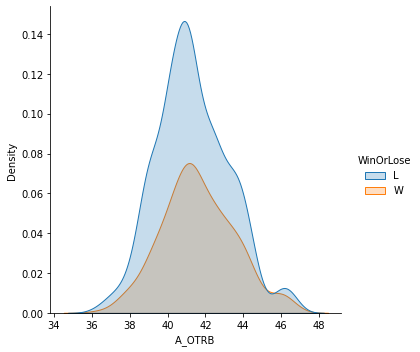

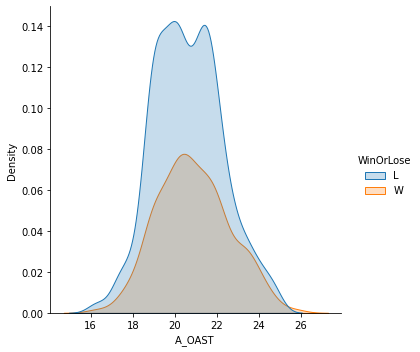

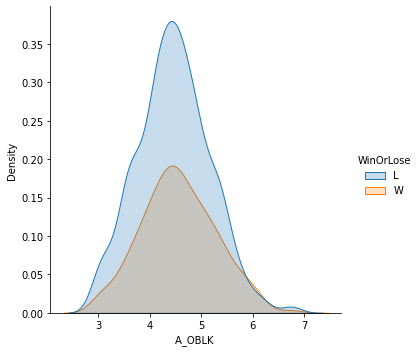

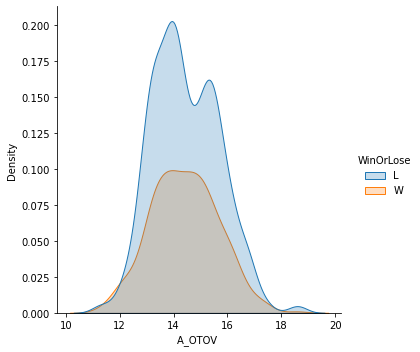

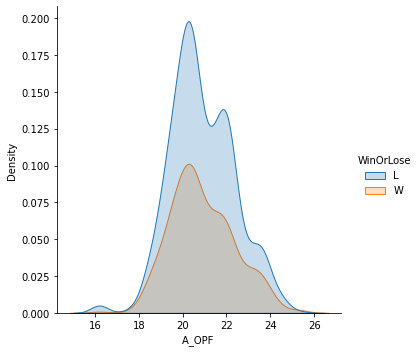

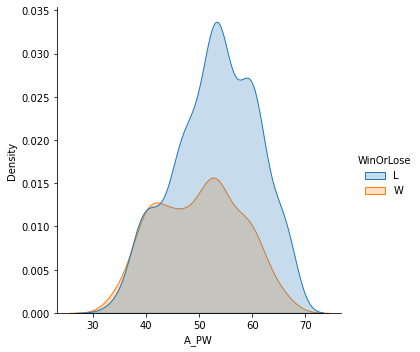

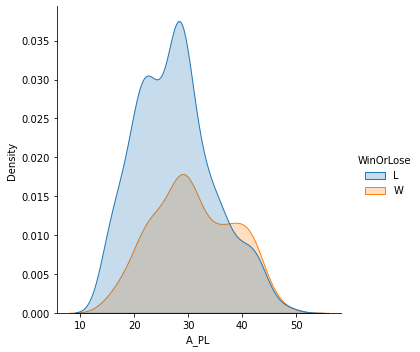

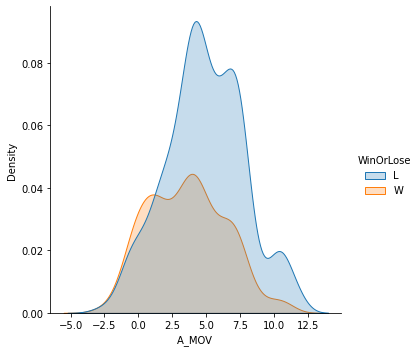

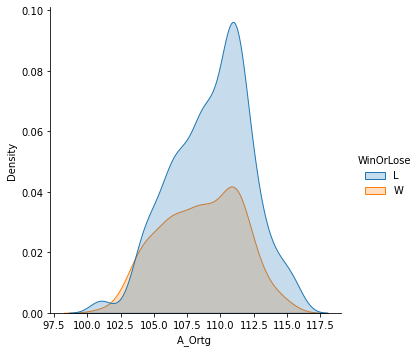

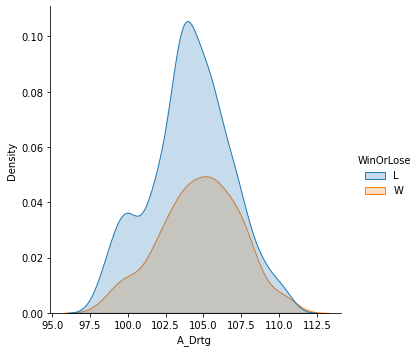

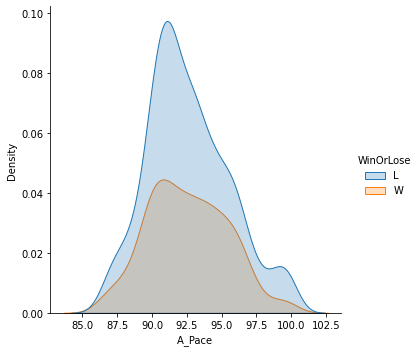

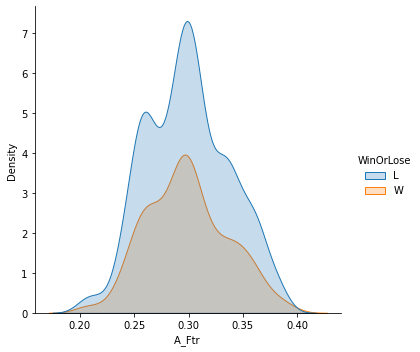

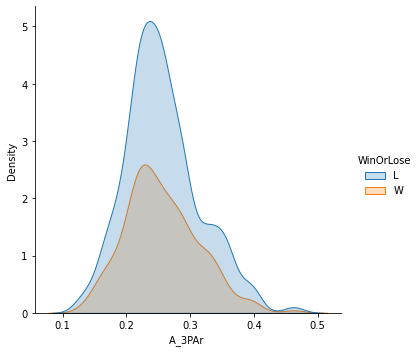

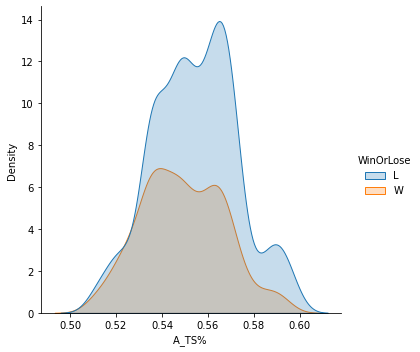

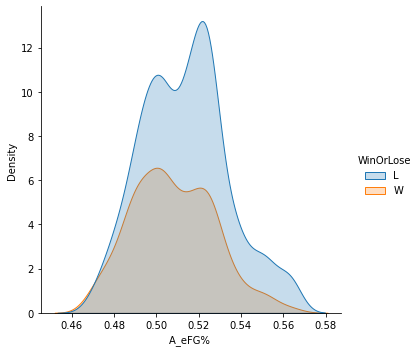

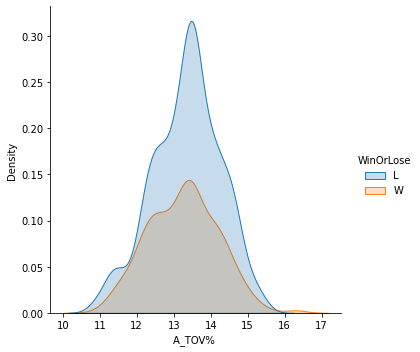

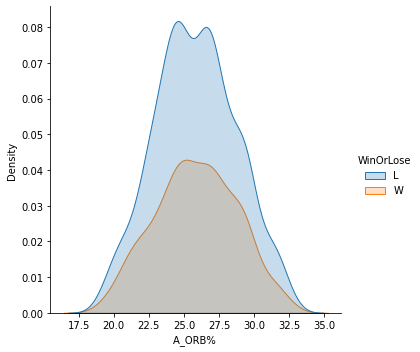

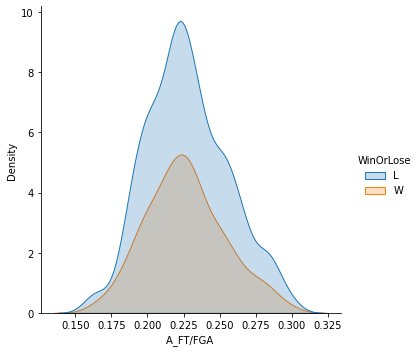

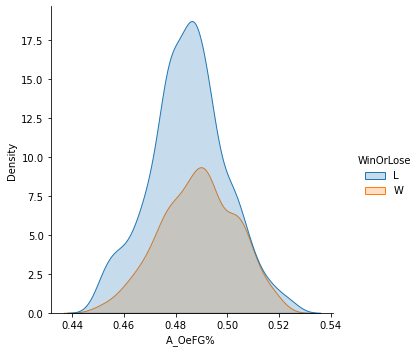

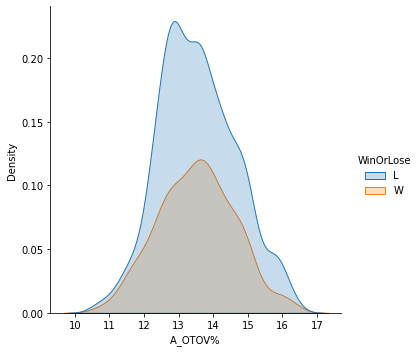

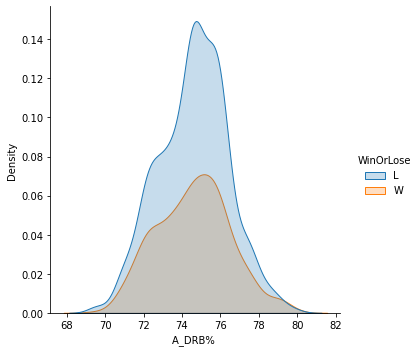

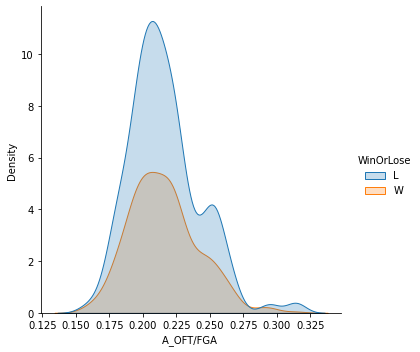

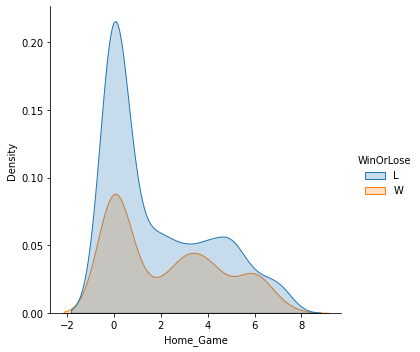

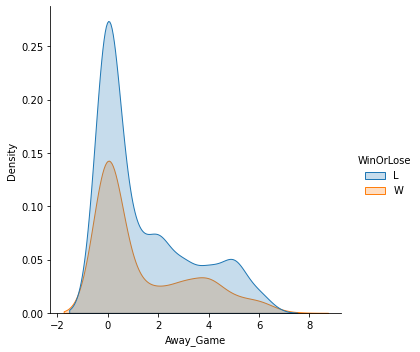

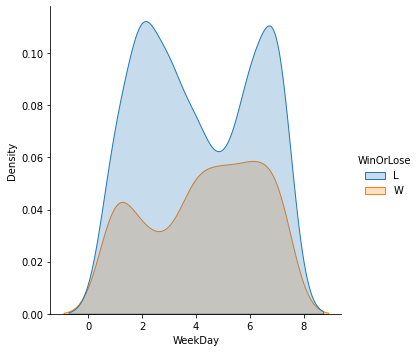

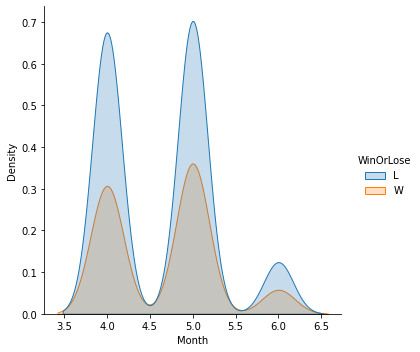

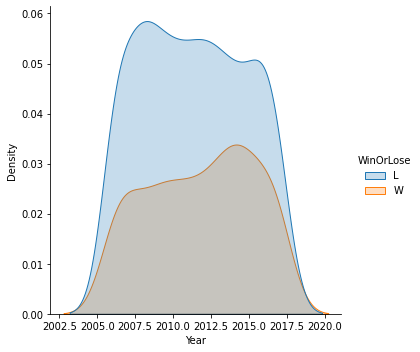

In [17]:
for aux in data_train.columns:
    if data_train.loc[:, aux].dtypes == 'int64' or data_train.loc[:, aux].dtypes == 'float64':
        sns.displot(data=data_train, x=aux, hue='WinOrLose', kind = "kde", fill = True)
        plt.show()

**Verifica a correlação entre as variáveis**

Abaixo é calculado todas as correlações 2 a 2 dos atributos e as correlações maiores do 0,95 são mostradas. Para isso é utilizado o coeficiente de correlação de Spearman, por esse ser mais robusto do que o coeficiente de correlação de Pearson.

In [18]:
features_to_drop = []
all_coluns = data_train.columns
for ind1 in range(len(all_coluns)-1):
    aux1 = all_coluns[ind1]
    for ind2 in np.arange(ind1 + 1, len(all_coluns)):
        aux2 = all_coluns[ind2]
        if (data_train.loc[:, aux1].dtypes == 'int64' or data_train.loc[:, aux1].dtypes == 'float64') and (data_train.loc[:, aux2].dtypes == 'int64' or data_train.loc[:, aux2].dtypes == 'float64'):
            coef_spearman = abs(stats.spearmanr(data_train.loc[:, aux1],data_train.loc[:, aux2])[0])
            coef_pearson = abs(stats.pearsonr(data_train.loc[:, aux1],data_train.loc[:, aux2])[0])
            if coef_spearman > 0.95 and aux1 != aux2:
                features_to_drop.append(aux2)
                print(aux1, aux2, coef_spearman, coef_pearson)

Game Year 0.9965058906382059 0.9964925064966178
H_Loss  H_W/D %  0.9681411231803768 0.9748609838754977
H_SRS  H_PL  0.9504676352908693 0.9589854998537506
H_SRS  H_MOV  0.9899989176941778 0.9926205003114822
H_3P  H_3PA  0.9808255562087926 0.9813296416774263
H_3P  H_3PAr  0.9735691804202666 0.9726229336128092
H_3PA  H_3PAr  0.987936087478606 0.9889805276754299
H_FTA  H_Ftr  0.9582646785250428 0.9628669943402057
H_PointsOpp  H_AvgPointsPerGameOpp  0.9525670077747158 0.7540000541386302
H_O3P  H_O3PA  0.9764983936457496 0.97904072985671
H_OFT  H_OFTA  0.9833281276784335 0.9843955576788072
H_PL  H_MOV  0.9622614267348621 0.9654598716204223
A_Loss  A_W/D %  0.9699197002748103 0.9759957793350831
A_SRS  A_MOV  0.9894665357665968 0.9926393250937198
A_3P  A_3PA  0.9800088874437001 0.9806819071333184
A_3P  A_3PAr  0.9727376458450983 0.9712787098678994
A_3PA  A_3PAr  0.9874928397354922 0.9889271288741102
A_FTA  A_Ftr  0.9571097424363402 0.9625199104054772
A_PointsOpp  A_AvgPointsPerGameOpp  0.95395

As colunas que possuem alta correlação com as demais podem ser não utilizadas pelos modelos de classificação, em outras palavras, isso pode ser um método de seleção de variáveis.

In [19]:
features_to_drop.append("H_Games ")
features_to_drop.append("A_Games ")
features_to_drop.append("Game")
features_to_drop.append("H_Team ")
features_to_drop.append("A_Team ")

In [20]:
features_to_drop

['Year',
 'H_W/D % ',
 'H_PL ',
 'H_MOV ',
 'H_3PA ',
 'H_3PAr ',
 'H_3PAr ',
 'H_Ftr ',
 'H_AvgPointsPerGameOpp ',
 'H_O3PA ',
 'H_OFTA ',
 'H_MOV ',
 'A_W/D % ',
 'A_MOV ',
 'A_3PA ',
 'A_3PAr ',
 'A_3PAr ',
 'A_Ftr ',
 'A_AvgPointsPerGameOpp ',
 'A_O3PA ',
 'A_OFTA ',
 'A_MOV ',
 'H_Games ',
 'A_Games ',
 'Game',
 'H_Team ',
 'A_Team ']

# 3) Valor da informação (IV) e peso de evidência (WOE)

O valor da informação e o peso de evidência são medidas que, especificamente, quando se trata de problemas de classificação igual ao que temos neste projeto, podem nos mostrar relações de importância entre uma variável independente (atributo) e uma variável dependente (Win or Lose no nosso caso).

São medidas que independem de um modelo ou algo a ser feito antes, basta termos os nossos dados prontos para uso (limpos), que já conseguimos calculá-las, diferente das outras técnicas de feature importance, em que são obtidas essas informações de importância a partir de um modelo definido. E para isso é utilizado o valor da informação (IV), sendo este calculado utilizando o peso de evidência (WOE), mostrando numericamente a 'importância' de um determinado atributo em relação à variável resposta.

Abaixo segue a tabela que iremos utilizar para classificarmos os atributos de acordo com sua ordem de importância.

Mais sobre em: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

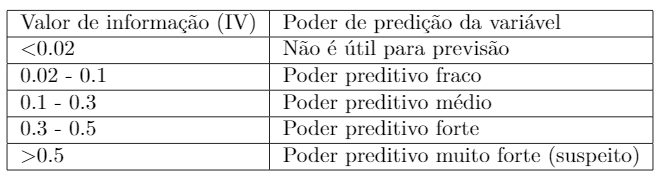

In [21]:
#Funções para calculo do IV e do WOE
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [22]:
data_train = data_train.replace(['W', 'L'], [1, 0])

In [23]:
final_iv, IV = data_vars(data_train,data_train.WinOrLose)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
#Features mais importantes para predição de acordo com IV
IV.sort_values('IV',ascending = False)
IV = IV.sort_values('IV',ascending = False)
pd.set_option('display.max_rows', 1000)
IV


,VAR_NAME,IV
119,H_PW,0.261350
23,A_Loss,0.260715
129,H_W/D %,0.257836
62,A_W/D %,0.244682
55,A_SRS,0.236328
51,A_PL,0.231334
24,A_MOV,0.224271
127,H_Team,0.214980
63,A_Wins,0.202264
91,H_MOV,0.193913


# 4) Seleção de atributos manual

In [25]:
# Lista de colunas no conjunto de treino
for col in data_train.columns:
    print(col)

Game
H_Team 
H_Wins 
H_Loss 
H_W/D % 
H_SRS 
H_Games 
H_TotalPoints 
H_AvgPointsPerGame 
H_FG 
H_FGA 
H_FG% 
H_3P 
H_3PA 
H_3P% 
H_2P 
H_2PA 
H_2P% 
H_FT 
H_FTA 
H_FT% 
H_ORB 
H_DRB 
H_TRB 
H_AST 
H_BLK 
H_TOV 
H_PF 
H_PointsOpp 
H_AvgPointsPerGameOpp 
H_OFG 
H_OFGA 
H_OFG% 
H_O3P 
H_O3PA 
H_O3P% 
H_O2P 
H_O2PA 
H_O2P% 
H_OFT 
H_OFTA 
H_OFT% 
H_OORB 
H_ODRB 
H_OTRB 
H_OAST 
H_OBLK 
H_OTOV 
H_OPF 
H_PW 
H_PL 
H_MOV 
H_Ortg 
H_Drtg 
H_Pace 
H_Ftr 
H_3PAr 
H_TS% 
H_eFG% 
H_TOV% 
H_ORB% 
H_FT/FGA 
H_OeFG% 
H_OTOV% 
H_DRB% 
H_OFT/FGA 
A_Team 
A_Wins 
A_Loss 
A_W/D % 
A_SRS 
A_Games 
A_TotalPoints 
A_AvgPointsPerGame 
A_FG 
A_FGA 
A_FG% 
A_3P 
A_3PA 
A_3P% 
A_2P 
A_2PA 
A_2P% 
A_FT 
A_FTA 
A_FT% 
A_ORB 
A_DRB 
A_TRB 
A_AST 
A_BLK 
A_TOV 
A_PF 
A_PointsOpp 
A_AvgPointsPerGameOpp 
A_OFG 
A_OFGA 
A_OFG% 
A_O3P 
A_O3PA 
A_O3P% 
A_O2P 
A_O2PA 
A_O2P% 
A_OFT 
A_OFTA 
A_OFT% 
A_OORB 
A_ODRB 
A_OTRB 
A_OAST 
A_OBLK 
A_OTOV 
A_OPF 
A_PW 
A_PL 
A_MOV 
A_Ortg 
A_Drtg 
A_Pace 
A_Ftr 
A_3PAr 
A_TS% 
A_eF

In [26]:
# Pegando as features mais importantes e realizando testes com diferentes combinações delas.
variables_used = ['H_W/D % ', 'H_FG% ', 'H_FT% ',
                  'A_W/D % ',
                  'WeekDay'] # Esta foi a que tivemos um melhores resultado nos testes feitos abaixo.

X = data_train[variables_used].values
y = data_train.loc[:, "WinOrLose"]
X_test = data_test[variables_used].values

Essa seleção de atributos manual se pautou, basicamente, nos testes feitos com o modelo de classificação Naive Bayes, para tal é interessante que se tenha "poucos" atributos na classificação e por isso, resolvemos fazer essa selação manual. Ainda, a estimativa não paramétrica de kernel para a função densidade de probabilidade também teve uma forte influência para a escolha dos atributos.

Eles serão utilizados na classificação via Naive Bayes abaixo.

# 5) Naive Bayes

Cross Validation para o Naive Bayes.

In [27]:
model = GaussianNB()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=7)
scores = cross_val_score(model, X, y, scoring = 'balanced_accuracy', cv = cv, n_jobs=-1)

In [28]:
print(np.mean(scores), np.std(scores))

0.6010785353535354 0.04233344184350744


Temos que em média a nossa acurácia é de $60,1\%$.

Ajuste do modelo e preparação para a submissão.

In [29]:
model.fit(X, y)
predict = model.predict(X_test)

sub = pd.DataFrame(data = {'Game':data_test.loc[:, "Game"], 'WinOrLose':predict})
sub.loc[:, "WinOrLose"].replace([0, 1],["L", "W"], inplace = True)
sub.to_csv('submission_naives.csv',index=False)
sub

,Game,WinOrLose
0,0,L
1,1,W
2,2,L
3,3,L
4,4,L
5,5,L
6,6,L
7,7,L
8,8,L
9,9,L


# 6) Ada Boosting

Fazemos a classificação usando o Ada Boosting.

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

Abaixo utilizamos o grid search.

In [31]:
from sklearn.model_selection import GridSearchCV

# hiperparametros para ajustar
param_grid = {
    'n_estimators': [100,200,300,400,500,600],
    'learning_rate': [0.01,0.1,1,10]
}

gs_ab = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid, n_jobs=20, scoring = "balanced_accuracy")
gs_ab.fit(X,y)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=20,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='balanced_accuracy')

Os melhores parâmetros são mostrados abaixo.

In [32]:
gs_ab.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

Abaixo temos o cross validation.

In [33]:
model = AdaBoostClassifier(n_estimators=gs_ab.best_params_["n_estimators"], learning_rate = gs_ab.best_params_["learning_rate"], algorithm='SAMME')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=7)
scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=20)

In [34]:
print(np.mean(scores),np.std(scores))

0.5495274447774448 0.03712848611823053


Abaixo tem-se o ajuste do modelo ajustado com os melhores parâmetros e a predição.

In [35]:
model.fit(X,y)
predict = model.predict(X_test)

sub = pd.DataFrame(data = {'Game':data_test.loc[:, "Game"], 'WinOrLose':predict})
sub.loc[:, "WinOrLose"].replace([0, 1],["L", "W"], inplace = True)
sub.to_csv('submission.csv',index=False)

sub

,Game,WinOrLose
0,0,L
1,1,L
2,2,L
3,3,L
4,4,L
5,5,L
6,6,L
7,7,L
8,8,L
9,9,L


# 7) Support Vector Machine

Abaixo fazemos uso do Support Vector Machine para a classificação.

In [36]:
grid_params = {
    'C': [int(x) for x in np.linspace(1, 100, num = 5)], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'gamma': ['auto', 'scale'] 
}

gs = GridSearchCV(
  svm.SVC(),
  grid_params,
  verbose = 0, #don't print progress
  cv = 5, #cross validation
  n_jobs = -1, #to use all processors
  scoring = "balanced_accuracy"
)

gs_results = gs.fit(X, y)

print('       Melhores parâmetros:', gs_results.best_params_)

       Melhores parâmetros: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


Em seguida temos a validação cruzada.

In [37]:
model = svm.SVC(kernel = gs_results.best_params_['kernel'], C = gs_results.best_params_['C'], 
                gamma = gs_results.best_params_['gamma'])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=7)
scores = cross_val_score(model, X, y, scoring = "balanced_accuracy", cv=cv, n_jobs=-1)

print(np.mean(scores), np.std(scores))

0.5411254856254856 0.03157764868152853


Abaixo tem-se o ajuste do modelo ajustado com os melhores parâmetros e a predição.

In [38]:
model.fit(X,y)
predict = model.predict(X_test)

sub = pd.DataFrame(data = {'Game':data_test.loc[:, "Game"], 'WinOrLose':predict})
sub.loc[:, "WinOrLose"].replace([0, 1],["L", "W"], inplace = True)
sub.to_csv('submission.csv',index=False)

sub

,Game,WinOrLose
0,0,L
1,1,L
2,2,L
3,3,L
4,4,L
5,5,L
6,6,L
7,7,L
8,8,L
9,9,L


# 8) Random Forest

## GridSearch Random Forest

In [39]:
# values = []
# for i in np.arange(1,50):
parameters = {'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': np.arange(1, 25,2)}

model = RandomForestClassifier()
best_model = GridSearchCV(model, param_grid = parameters, cv = 5, scoring="balanced_accuracy")
best_model.fit(X, y)
y_pred = best_model.predict(X) 
print('Melhores parâmetros:', best_model.best_params_, "\n")
n_estimators = best_model.best_params_.values()

Melhores parâmetros: {'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 19} 



In [40]:
#Realizando a validação do modelo e obtendo a acurácia média com os parâmetros encontrados acima pelo GridSearch
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=7)
vacc = []

for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = RandomForestClassifier(bootstrap= True, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 9)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = balanced_accuracy_score(y_test, y_pred)
    vacc.append(score)

In [41]:
print('\n Média Acurácia:',np.mean(vacc),'| Dsv.Padr Acurácia :', np.std(vacc,ddof=1 ))


 Média Acurácia: 0.5539168054168053 | Dsv.Padr Acurácia : 0.047256334207882174


Podemos ver que a media de acurácia do modelo Random Forest foi de <b>0.55

In [42]:
model.fit(X,y)
predict = model.predict(X_test)

sub = pd.DataFrame(data = {'Game':data_test.loc[:, "Game"], 'WinOrLose':predict})
sub.loc[:, "WinOrLose"].replace([0, 1],["L", "W"], inplace = True)
sub.to_csv('submission.csv',index=False)

sub

,Game,WinOrLose
0,0,L
1,1,L
2,2,L
3,3,W
4,4,W
5,5,W
6,6,L
7,7,L
8,8,L
9,9,L


# 9) Conclusão

Como podemos ver, o modelo que obteve maior acurácia balanceada foi o Naive Bayes, portanto submetemos no Kaggle os resultados desse modelo e obtivemos nossa maior acurácia.##